In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
%pylab inline

Populating the interactive namespace from numpy and matplotlib


In [3]:
import pandas as pd
import seaborn as sns; sns.set(style="white", color_codes=True)

In [4]:
pd.__version__

'1.3.5'

In [5]:
import statsmodels as sm
from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.tsa.statespace.sarimax import SARIMAX
from statsmodels.tsa.holtwinters import ExponentialSmoothing
sm.__version__

'0.14.0'

In [6]:
import prophet
from prophet import Prophet
prophet.__version__

'1.1.4'

In [7]:
import tensorflow as tf
from tensorflow.keras import Sequential
from tensorflow.keras.layers import Dense, LSTM
tf.__version__

'2.13.0'

In [8]:
import xgboost as xg
from xgboost import XGBRegressor
xg.__version__

'1.7.6'

In [9]:
from src.ts_functions import smape
from src.ts_data import TSData
from src.minmax_scaling import MinMaxScaling

# Time Series Model Templates

A comparison of several time series models on a simple univariate dataset (the airline passengers data).

### Load data

In [10]:
ts = TSData.from_file("./data/AirPassengers.csv")

In [11]:
ts.data.head()

,month,passengers
0,1949-01-01,112
1,1949-02-01,118
2,1949-03-01,132
3,1949-04-01,129
4,1949-05-01,121


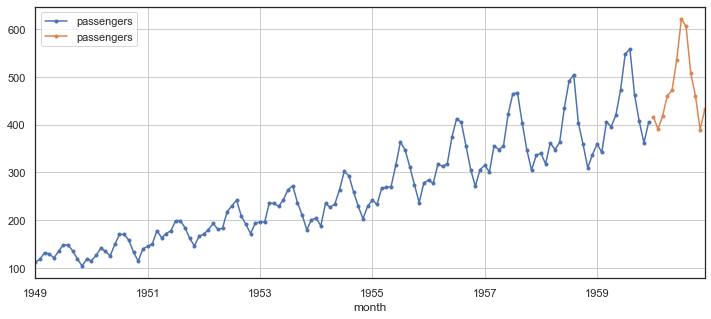

In [12]:
fig, ax = plt.subplots(1, figsize=(12, 5))
ts.train_data.set_index("month").plot(marker=".", ax=ax, label="train");
ts.test_data.set_index("month").plot(marker=".", ax=ax, label="test");
plt.grid();

In [13]:
ts.set_column_names("ds", "y")

### Persistence model

Very simple model that we can use as a baseline. Takes the previous month for the prediction taking into account the seasonality.

In [14]:
forecast = ts.train_data["y"][-12:]
forecast.index = ts.test_data.index
forecast.name = "yhat"

In [15]:
df_test_p = ts.test_data.join(forecast)

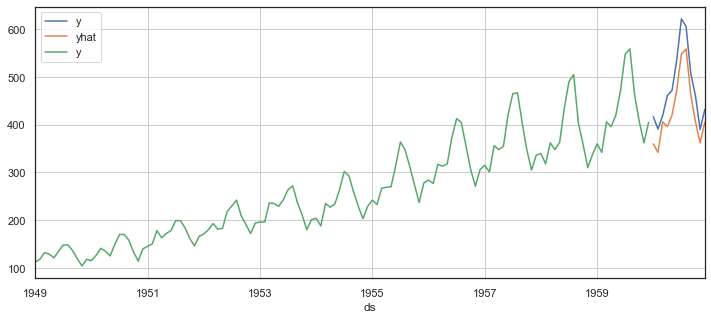

In [16]:
fig, ax = plt.subplots(1, figsize=(12, 5))
df_test_p.set_index("ds").plot(ax=ax)
ts.train_data.set_index("ds").plot(ax=ax)
plt.grid();

In [17]:
print("sMAPE on test set : {:.4f} %".format(smape(df_test_p["yhat"], df_test_p["y"])))

sMAPE on test set : 63.4308 %


### Min-max scaling model

A simple model which scales the previous period(s) by a scaling factor that is determined by the trend of the minimum and maximum in each period over time.

In [18]:
model_params = {
    "seasonality": 12,
    "lookback_periods": 6,
}

In [19]:
model = MinMaxScaling(**model_params)

In [20]:
ignore_years = 3   # do not fit to the first 3 years where the trend is non-linear
model.fit(ts.train_data["y"][12*ignore_years:])

In [21]:
forecast = pd.Series(model.forecast(1), name="yhat", index=ts.test_data.index)

In [22]:
df_test_p = ts.test_data.join(forecast)

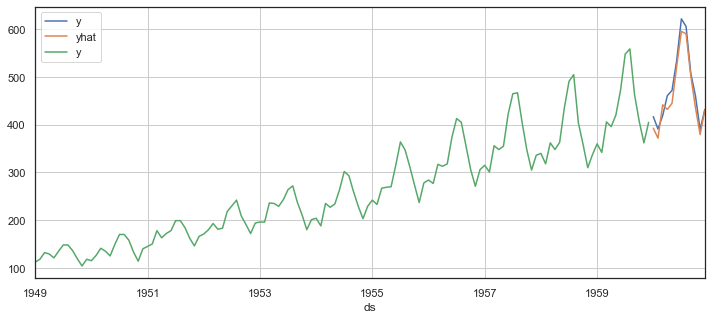

In [23]:
fig, ax = plt.subplots(1, figsize=(12, 5))
df_test_p.set_index("ds").plot(ax=ax)
ts.train_data.set_index("ds").plot(ax=ax)
plt.grid();

In [24]:
print("sMAPE on test set : {:.4f} %".format(smape(df_test_p["yhat"], df_test_p["y"])))

sMAPE on test set : 23.7092 %


### Prophet model

https://facebook.github.io/prophet/

In [25]:
model_params = {
    "daily_seasonality": False,
    "weekly_seasonality": False,
    "yearly_seasonality": 12,
    "seasonality_mode": "multiplicative",
    "interval_width": 0.95,
    "uncertainty_samples": 200,
}

In [26]:
model = Prophet(**model_params)

In [27]:
model.fit(ts.train_data)

21:47:30 - cmdstanpy - INFO - Chain [1] start processing
21:47:30 - cmdstanpy - INFO - Chain [1] done processing


In [28]:
future = model.make_future_dataframe(periods=12, freq="MS")
forecast = model.predict(future)

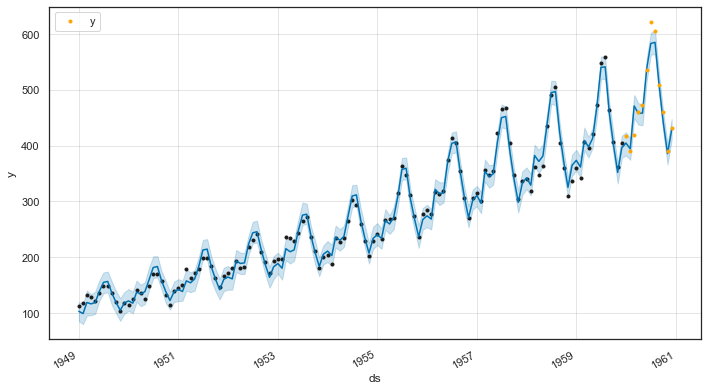

In [29]:
model.plot(forecast);
ts.test_data.set_index("ds").plot(c="orange", marker='.', linestyle="None", ax=plt.gca(), label="test");
plt.grid();

In [30]:
df_test_p = ts.test_data.merge(forecast.iloc[-12:][["ds", "yhat"]])

In [31]:
print("sMAPE on test set : {:.4f} %".format(smape(df_test_p["yhat"], df_test_p["y"])))

sMAPE on test set : 18.3443 %


### SARIMAX model

https://www.statsmodels.org/dev/generated/statsmodels.tsa.statespace.sarimax.SARIMAX.html

In [32]:
model_params = {
    "order": (1, 0, 0),
    "seasonal_order": (1, 0, 0, 12),
    "trend": "ct",
}

In [33]:
model = SARIMAX(ts.train_data["y"], **model_params)

In [34]:
result = model.fit()
print(result.summary())

RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            5     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  4.78543D+00    |proj g|=  8.21185D-01

At iterate    5    f=  4.46751D+00    |proj g|=  6.59643D-02

At iterate   10    f=  4.44533D+00    |proj g|=  1.23440D-01

At iterate   15    f=  4.18804D+00    |proj g|=  7.32856D-01

At iterate   20    f=  4.17191D+00    |proj g|=  5.98739D-02

At iterate   25    f=  3.98418D+00    |proj g|=  1.64103D+00

At iterate   30    f=  3.87566D+00    |proj g|=  1.78089D-01

At iterate   35    f=  3.84469D+00    |proj g|=  4.38253D-01

At iterate   40    f=  3.84116D+00    |proj g|=  1.17305D-02

At iterate   45    f=  3.84114D+00    |proj g|=  2.82242D-05

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = nu

In [35]:
forecast = result.forecast(12)
forecast.name = "yhat"
predict = result.get_prediction().predicted_mean
predict.name = "yhat"
ci = result.get_prediction().conf_int(alpha=0.05)

In [36]:
df_test_p = ts.test_data.join(forecast)
df_train_p = ts.train_data.join(predict)

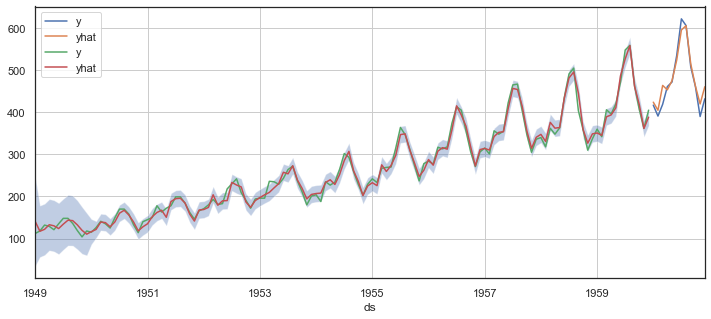

In [37]:
fig, ax = plt.subplots(1, figsize=(12, 5))
df_test_p.set_index("ds").plot(ax=ax)
df_train_p.set_index("ds").plot(ax=ax)
ax.fill_between(df_train_p["ds"].to_numpy(), ci["lower y"].to_numpy(), ci["upper y"].to_numpy(), alpha=0.35);
plt.grid();

In [38]:
print("sMAPE on test set : {:.4f} %".format(smape(df_test_p["yhat"], df_test_p["y"])))

sMAPE on test set : 19.7758 %


### Holt-Winters model

https://www.statsmodels.org/dev/generated/statsmodels.tsa.holtwinters.ExponentialSmoothing.html

In [39]:
model_params = {
    "trend": "add",
    "damped_trend": True,
    "seasonal": "mul",
    "seasonal_periods": 12,
    "use_boxcox": False,
}

In [40]:
model = ExponentialSmoothing(ts.train_data["y"], **model_params)

In [41]:
result = model.fit()
print(result.summary())

                       ExponentialSmoothing Model Results                       
Dep. Variable:                        y   No. Observations:                  132
Model:             ExponentialSmoothing   SSE                          13236.471
Optimized:                         True   AIC                            642.247
Trend:                         Additive   BIC                            691.254
Seasonal:                Multiplicative   AICC                           649.032
Seasonal Periods:                    12   Date:                 Sun, 20 Aug 2023
Box-Cox:                          False   Time:                         21:47:47
Box-Cox Coeff.:                    None                                         
                          coeff                 code              optimized      
---------------------------------------------------------------------------------
smoothing_level               0.3879362                alpha                 True
smoothing_trend          

In [42]:
forecast = result.forecast(12)
forecast.name = "yhat"
predict = result.fittedvalues
predict.name = "yhat"

In [43]:
df_test_p = ts.test_data.join(forecast)
df_train_p = ts.train_data.join(predict)

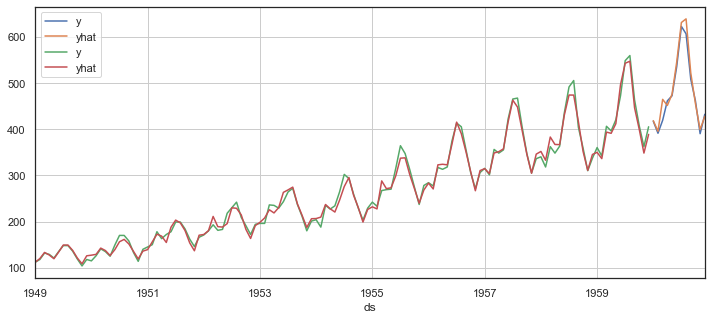

In [44]:
fig, ax = plt.subplots(1, figsize=(12, 5))
df_test_p.set_index("ds").plot(ax=ax)
df_train_p.set_index("ds").plot(ax=ax)
plt.grid();

In [45]:
print("sMAPE on test set : {:.4f} %".format(smape(df_test_p["yhat"], df_test_p["y"])))

sMAPE on test set : 14.9738 %


### LSTM model

https://keras.io/api/layers/recurrent_layers/lstm/

Simple LSTM layer with FF layer to produce output series

In [46]:
# reload data for use in neural net models
ts_nn = TSData.from_file("./data/AirPassengers.csv")
ts_nn.set_column_names("ds", "y")

In [47]:
look_back = 3
look_fwd = 12

In [48]:
# perform differencing and rescaling
ts_nn.difference()
ts_nn.min_max_scale()

In [49]:
ts_nn.data.head()

,ds,y
0,1949-01-01,NaN
1,1949-02-01,0.569149
2,1949-03-01,0.611702
3,1949-04-01,0.521277
4,1949-05-01,0.494681


In [50]:
ts_nn.series_to_supervised(look_back, look_fwd)

In [51]:
ts_nn.data.head()

,ds,y(t-3),y(t-2),y(t-1),y(t+0),y(t+1),y(t+2),y(t+3),y(t+4),y(t+5),y(t+6),y(t+7),y(t+8),y(t+9),y(t+10),y(t+11)
4,1949-05-01,0.569149,0.611702,0.521277,0.494681,0.611702,0.606383,0.537234,0.473404,0.446809,0.457447,0.611702,0.521277,0.595745,0.617021,0.505319
5,1949-06-01,0.611702,0.521277,0.494681,0.611702,0.606383,0.537234,0.473404,0.446809,0.457447,0.611702,0.521277,0.595745,0.617021,0.505319,0.484043
6,1949-07-01,0.521277,0.494681,0.611702,0.606383,0.537234,0.473404,0.446809,0.457447,0.611702,0.521277,0.595745,0.617021,0.505319,0.484043,0.664894
7,1949-08-01,0.494681,0.611702,0.606383,0.537234,0.473404,0.446809,0.457447,0.611702,0.521277,0.595745,0.617021,0.505319,0.484043,0.664894,0.648936
8,1949-09-01,0.611702,0.606383,0.537234,0.473404,0.446809,0.457447,0.611702,0.521277,0.595745,0.617021,0.505319,0.484043,0.664894,0.648936,0.537234


In [52]:
# reshape training data into [samples, timesteps, features]
X = ts_nn.train_data.filter(like="y").iloc[:, :look_back].values
X = X.reshape(X.shape[0], 1, X.shape[1])
y = ts_nn.train_data.filter(like="y").iloc[:, look_back:].values

In [53]:
model = Sequential()
model.add(LSTM(12, batch_input_shape=(1, X.shape[1], X.shape[2]), stateful=True))
model.add(Dense(y.shape[1]))
model.compile(loss="mean_squared_error", optimizer=tf.keras.optimizers.legacy.Adam())

In [54]:
# fit network reseting state between epochs
n_epoch = 300
for i in range(n_epoch):
    verbose = 1 if not i % 20 else 0
    model.fit(X, y, epochs=1, batch_size=1, verbose=verbose, shuffle=False)
    model.reset_states()

117/117 [==============================] - 1s 6ms/step - loss: 0.0021


In [55]:
X_test = ts_nn.test_data.filter(like="y").iloc[:, :look_back].values
X_test = X_test.reshape(X_test.shape[0], 1, X_test.shape[1])

In [56]:
forecast = model.predict(X_test, batch_size=1)[-1]

12/12 [==============================] - 0s 3ms/step


In [57]:
# invert differencing and scaling and revert to TS data
forecast = ts_nn.inv_min_max_scale(forecast.reshape(-1, 1))
ts_nn.reset_data()
ts_nn.set_column_names("ds", "y")
forecast = ts_nn.inv_difference(forecast, [ts_nn.train_data["y"].iloc[-1]])[1:]

In [58]:
df_test_p = ts.test_data.join(pd.Series(forecast.reshape(-1), name="yhat", index=ts_nn.test_data.index))

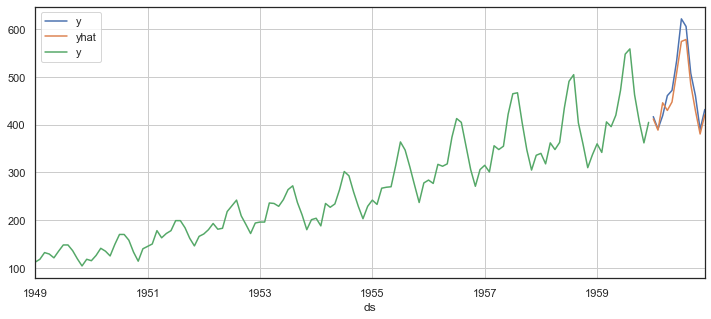

In [59]:
fig, ax = plt.subplots(1, figsize=(12, 5))
df_test_p.set_index("ds").plot(ax=ax)
ts.train_data.set_index("ds").plot(ax=ax)
plt.grid();

In [60]:
print("sMAPE on test set : {:.4f} %".format(smape(df_test_p["yhat"], df_test_p["y"])))

sMAPE on test set : 27.1797 %


### Windowed MPL model

In [61]:
look_back = 6
look_fwd = 12

In [62]:
# perform differencing and rescaling
ts_nn.difference()
ts_nn.min_max_scale()

In [63]:
ts_nn.series_to_supervised(look_back, look_fwd)

In [64]:
ts_nn.data.head()

,ds,y(t-6),y(t-5),y(t-4),y(t-3),y(t-2),y(t-1),y(t+0),y(t+1),y(t+2),y(t+3),y(t+4),y(t+5),y(t+6),y(t+7),y(t+8),y(t+9),y(t+10),y(t+11)
7,1949-08,0.569149,0.611702,0.521277,0.494681,0.611702,0.606383,0.537234,0.473404,0.446809,0.457447,0.611702,0.521277,0.595745,0.617021,0.505319,0.484043,0.664894,0.648936
8,1949-09,0.611702,0.521277,0.494681,0.611702,0.606383,0.537234,0.473404,0.446809,0.457447,0.611702,0.521277,0.595745,0.617021,0.505319,0.484043,0.664894,0.648936,0.537234
9,1949-10,0.521277,0.494681,0.611702,0.606383,0.537234,0.473404,0.446809,0.457447,0.611702,0.521277,0.595745,0.617021,0.505319,0.484043,0.664894,0.648936,0.537234,0.473404
10,1949-11,0.494681,0.611702,0.606383,0.537234,0.473404,0.446809,0.457447,0.611702,0.521277,0.595745,0.617021,0.505319,0.484043,0.664894,0.648936,0.537234,0.473404,0.404255
11,1949-12,0.611702,0.606383,0.537234,0.473404,0.446809,0.457447,0.611702,0.521277,0.595745,0.617021,0.505319,0.484043,0.664894,0.648936,0.537234,0.473404,0.404255,0.436170


In [65]:
# reshape training data
X = ts_nn.train_data.filter(like="y").iloc[:, :look_back].values
y = ts_nn.train_data.filter(like="y").iloc[:, look_back:].values

In [66]:
model = Sequential()
model.add(Dense(24, activation="relu", input_dim=look_back))
model.add(Dense(look_fwd))
model.compile(loss="mean_squared_error", optimizer=tf.keras.optimizers.legacy.Adam())

In [67]:
model.fit(X, y, epochs=2000, verbose=0)

In [68]:
X_test = ts_nn.test_data.filter(like="y").iloc[:, :look_back].values

In [69]:
forecast = model.predict(X_test)[-1]

1/1 [==============================] - 0s 29ms/step


In [70]:
# invert differencing and scaling and revert to TS data
forecast = ts_nn.inv_min_max_scale(forecast.reshape(-1, 1))
ts_nn.reset_data()
ts_nn.set_column_names("ds", "y")
forecast = ts_nn.inv_difference(forecast, [ts_nn.train_data["y"].iloc[-1]])[1:]

In [71]:
df_test_p = ts.test_data.join(pd.Series(forecast.reshape(-1), name="yhat", index=ts_nn.test_data.index))

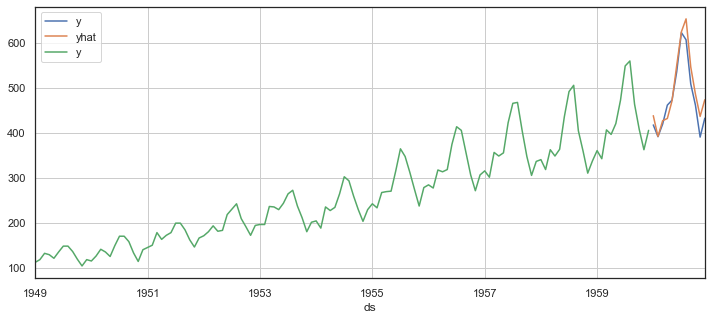

In [72]:
fig, ax = plt.subplots(1, figsize=(12, 5))
df_test_p.set_index("ds").plot(ax=ax)
ts.train_data.set_index("ds").plot(ax=ax)
plt.grid();

In [73]:
print("sMAPE on test set : {:.4f} %".format(smape(df_test_p["yhat"], df_test_p["y"])))

sMAPE on test set : 28.2133 %


### Gradient boosted trees

Using the xgboost regressor

In [74]:
look_back = 10
look_fwd = 12

In [75]:
# perform differencing and rescaling
ts_nn.difference()
ts_nn.min_max_scale()

In [76]:
ts_nn.series_to_supervised(look_back, look_fwd)

In [77]:
ts_nn.data.head()

,ds,y(t-10),y(t-9),y(t-8),y(t-7),y(t-6),y(t-5),y(t-4),y(t-3),y(t-2),...,y(t+2),y(t+3),y(t+4),y(t+5),y(t+6),y(t+7),y(t+8),y(t+9),y(t+10),y(t+11)
11,1949-12,0.569149,0.611702,0.521277,0.494681,0.611702,0.606383,0.537234,0.473404,0.446809,...,0.595745,0.617021,0.505319,0.484043,0.664894,0.648936,0.537234,0.473404,0.404255,0.436170
12,1950-01,0.611702,0.521277,0.494681,0.611702,0.606383,0.537234,0.473404,0.446809,0.457447,...,0.617021,0.505319,0.484043,0.664894,0.648936,0.537234,0.473404,0.404255,0.436170,0.675532
13,1950-02,0.521277,0.494681,0.611702,0.606383,0.537234,0.473404,0.446809,0.457447,0.611702,...,0.505319,0.484043,0.664894,0.648936,0.537234,0.473404,0.404255,0.436170,0.675532,0.563830
14,1950-03,0.494681,0.611702,0.606383,0.537234,0.473404,0.446809,0.457447,0.611702,0.521277,...,0.484043,0.664894,0.648936,0.537234,0.473404,0.404255,0.436170,0.675532,0.563830,0.563830
15,1950-04,0.611702,0.606383,0.537234,0.473404,0.446809,0.457447,0.611702,0.521277,0.595745,...,0.664894,0.648936,0.537234,0.473404,0.404255,0.436170,0.675532,0.563830,0.563830,0.686170


In [78]:
# reshape training data
X = ts_nn.train_data.filter(like="y").iloc[:, :look_back].values
y = ts_nn.train_data.filter(like="y").iloc[:, look_back:].values

In [79]:
model = XGBRegressor(n_estimators=200, max_depth=5, objective="reg:squarederror", colsample_bytree=0.9)

In [80]:
model.fit(X, y)

XGBRegressor(base_score=None, booster=None, callbacks=None,
             colsample_bylevel=None, colsample_bynode=None,
             colsample_bytree=0.9, early_stopping_rounds=None,
             enable_categorical=False, eval_metric=None, feature_types=None,
             gamma=None, gpu_id=None, grow_policy=None, importance_type=None,
             interaction_constraints=None, learning_rate=None, max_bin=None,
             max_cat_threshold=None, max_cat_to_onehot=None,
             max_delta_step=None, max_depth=5, max_leaves=None,
             min_child_weight=None, missing=nan, monotone_constraints=None,
             n_estimators=200, n_jobs=None, num_parallel_tree=None,
             predictor=None, random_state=None, ...)

In [81]:
X_test = ts_nn.test_data.filter(like="y").iloc[:, :look_back].values

In [82]:
forecast = model.predict(X_test)[-1]

In [83]:
# invert differencing and scaling and revert to TS data
forecast = ts_nn.inv_min_max_scale(forecast.reshape(-1, 1))
ts_nn.reset_data()
ts_nn.set_column_names("ds", "y")
forecast = ts_nn.inv_difference(forecast, [ts_nn.train_data["y"].iloc[-1]])[1:]

In [84]:
df_test_p = ts.test_data.join(pd.Series(forecast.reshape(-1), name="yhat", index=ts_nn.test_data.index))

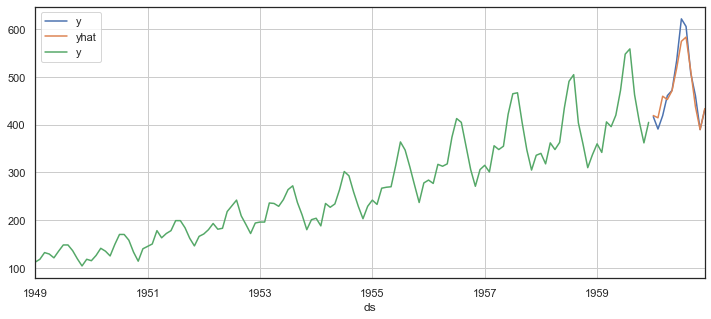

In [85]:
fig, ax = plt.subplots(1, figsize=(12, 5))
df_test_p.set_index("ds").plot(ax=ax)
ts.train_data.set_index("ds").plot(ax=ax)
plt.grid();

In [86]:
print("sMAPE on test set : {:.4f} %".format(smape(df_test_p["yhat"], df_test_p["y"])))

sMAPE on test set : 19.4499 %
